In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
def mean_and_cov(x):
    mean = np.mean(x, axis=0)
    cov = x.transpose() @ x / (x.shape[0] - 1.)
    return mean, cov


class Transform(object):
    def __init__(self, mean, cov):
        self.mean, self.cov = mean, cov
        self.eig_val, self.eig_vec = np.linalg.eig(self.cov)

    def __call__(self, x):
        x = x - self.mean
        x_normed = x @ self.eig_vec @ np.diag(np.power(self.eig_val, -0.5)) @ self.eig_vec.transpose()
        return x_normed

    def inv(self, x):
        x = x @ self.eig_vec @ np.diag(np.power(self.eig_val, 0.5)) @ self.eig_vec.transpose()
        x = x + self.mean
        return x



class Net(nn.Module):
    def __init__(self, dim):
        super().__init__()

        self.w = nn.Parameter(nn.init.orthogonal_(torch.empty(dim, dim)))

    def forward(self, x):
        return x @ self.w

    def norm(self):
        return self.w.transpose(1, 0) @ self.w

    def axis(self):
        w = self.w.data
        w /= w.pow(2).sum(dim=0, keepdim=True).pow(0.5)
        return w.numpy().transpose()

        

In [3]:
# https://github.com/pbrakel/anica
def get_data(seed=101, mix_dim=6, task_type='linear', samples=4000):
    # 10kHz, 4000 samples by default
    # This version of the task adds laplacian noise as a source and uses a
    # non-linear partially non-invertible, possibly overdetermined,
    # transformation.
    np.random.seed(seed)
    t = np.linspace(0, samples * 1e-4, samples)
    two_pi = 2 * np.pi
    s0 = np.sign(np.cos(two_pi * 155 * t))
    s1 = np.sin(two_pi * 800 * t)
    s2 = np.sin(two_pi * 300 * t + 6 * np.cos(two_pi * 60 * t))
    s3 = np.sin(two_pi * 90 * t)
    s4 = np.random.uniform(-1, 1, (samples,))
    s5 = np.random.laplace(0, 1, (samples,))
    x = np.stack([s0, s1, s2, s3, s4, s5])

    mix_mat = nn.init.orthogonal_(torch.empty(6, 6)).numpy()
    # mix_mat = np.random.uniform(-.5, .5, (mix_dim, 6))
    y = np.dot(mix_mat, x)
    if task_type in ['mlp', 'pnl']:
        y = np.tanh(y)
        if task_type == 'mlp':
            mix_mat2 = np.random.uniform(-.5, .5, (mix_dim, mix_dim))
            y = np.tanh(np.dot(mix_mat2, y))
    return t, x, y, mix_mat




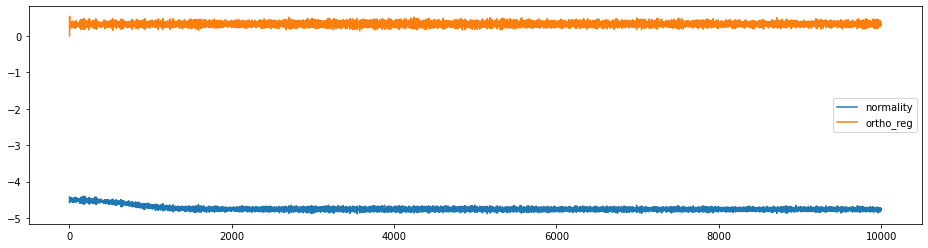

-4.75356388092041


In [17]:
def ortho_L1(norm):
    eye = torch.eye(len(norm))
    lower_one = torch.tril(torch.ones_like(eye))
    l1 = (torch.eye(len(norm)) - net.norm()).abs() * lower_one
    l1 = l1.sum()
    return l1

def ortho_L2(norm):
    eye = torch.eye(len(norm))
    lower_one = torch.tril(torch.ones_like(eye))
    l2 = (torch.eye(len(norm)) - net.norm()).pow(2.) * lower_one
    l2 = l2.sum()
    return l2



time_index, source, observation, _ = get_data()
data = observation.T

tr = Transform(*mean_and_cov(data))

net = Net(6)
optimizer = torch.optim.SGD(net.parameters(), 1e-2)
avg_normality, avg_ortho_reg = [], []
x_normed = tr(data)


for ep in range(10000):

    optimizer.zero_grad()
    seperated = net(torch.FloatTensor(x_normed))
    normality_loss = (1. - seperated.tanh().square()).log().sum(dim=-1).mean()
    ortho_reg_loss = ortho_L1(net.norm())
    loss = normality_loss + ortho_reg_loss # minimize normality
    loss.backward()
    optimizer.step()
    avg_normality.append(normality_loss.item())
    avg_ortho_reg.append(ortho_reg_loss.item())


plt.figure(figsize=(16, 4))
plt.plot(range(1, 1 + len(avg_normality)), avg_normality, label='normality')
plt.plot(range(1, 1 + len(avg_ortho_reg)), avg_ortho_reg, label='ortho_reg')
plt.legend()
plt.show()
print(avg_normality[-1])

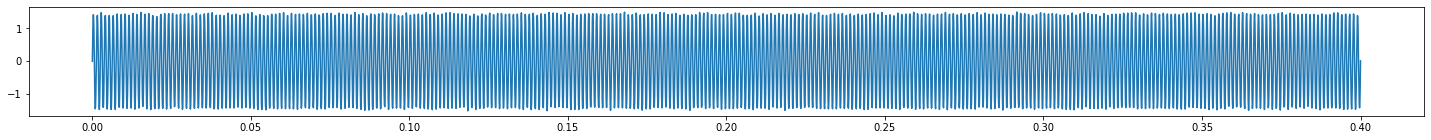

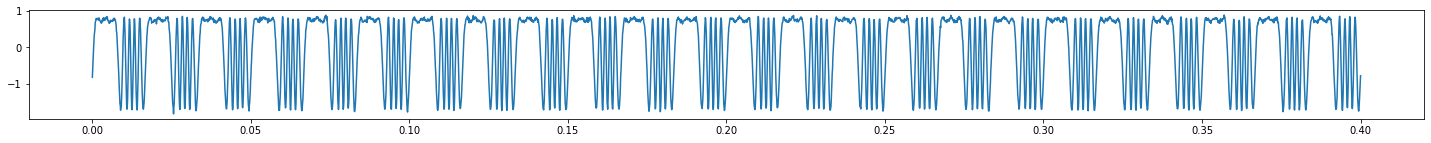

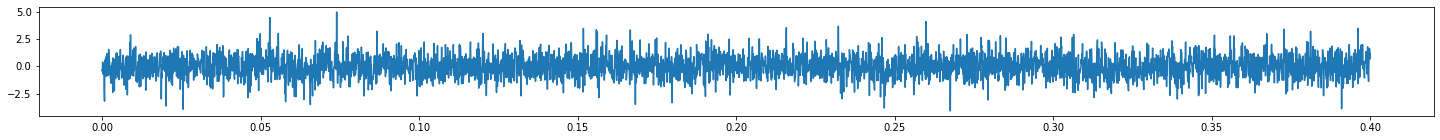

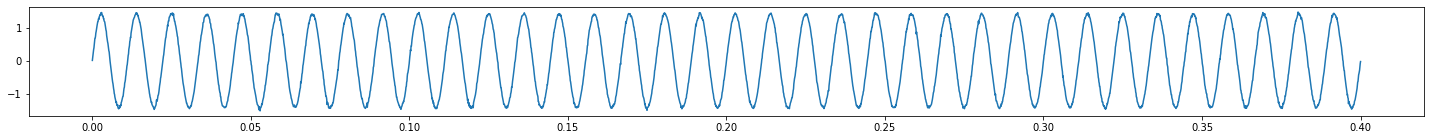

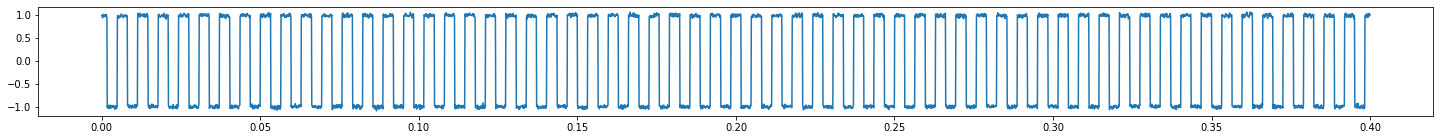

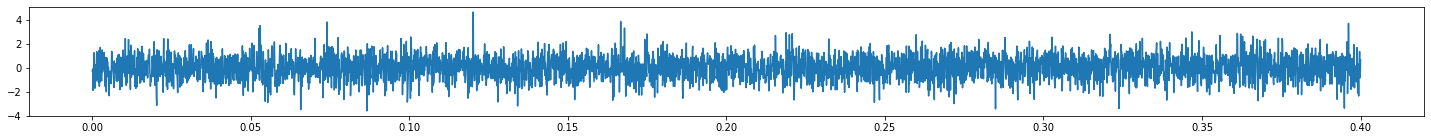

In [18]:
# ica result
s = seperated.detach().cpu().numpy()

for i in range(6):
    plt.figure(figsize=(25, 2))
    plt.plot(time_index, s[:, i])
plt.show()

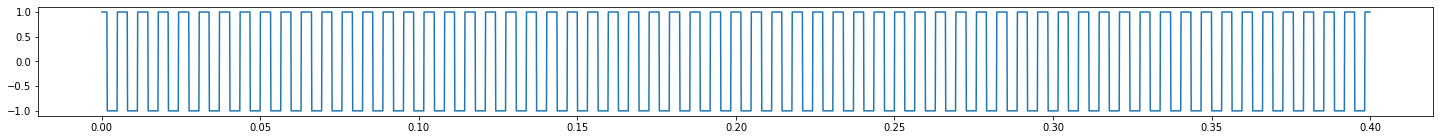

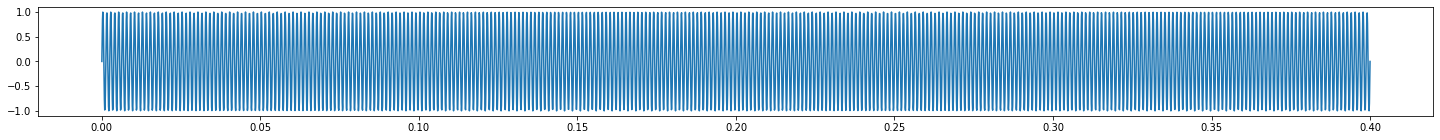

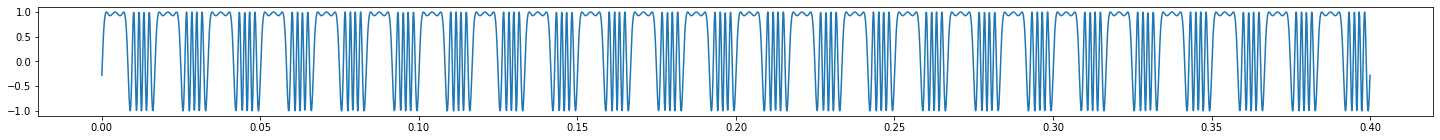

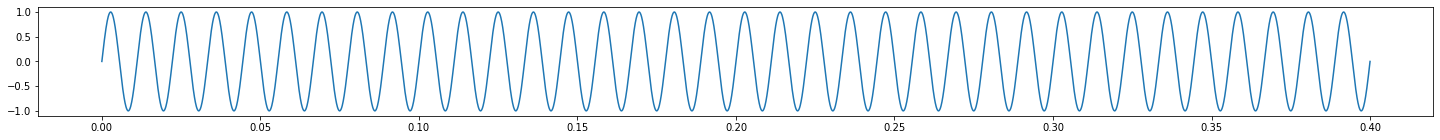

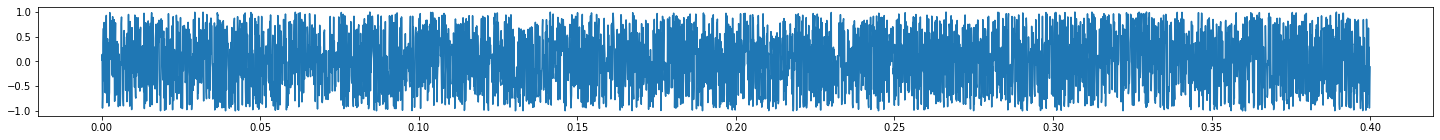

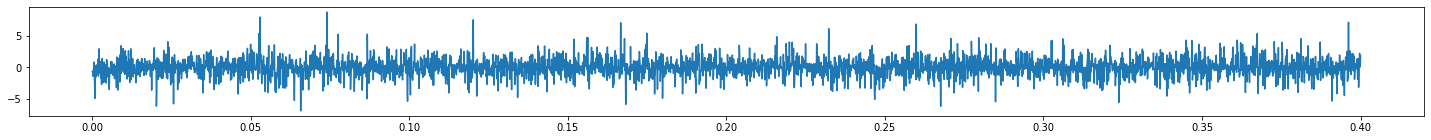

In [19]:
# original source
for i in range(6):
    plt.figure(figsize=(25, 2))
    plt.plot(time_index, source[i])
plt.show()